# Imports

In [1]:
#####IMPORTS######
import numpy as np
import os
import sys
import pickle
import argparse
import re
import scipy.stats as stats
import matplotlib.pyplot as plt
import csv
import shutil
from numpy.random import default_rng
rng = default_rng()
from matplotlib import cm
sys.path.append('/media/bigdata/firing_space_plot/ephys_data')
sys.path.append('/media/bigdata/firing_space_plot/changepoint_mcmc')
from ephys_data import ephys_data
print('Imports Done')

Imports Done


In [2]:
###Define Correlation Calculation Functions####

def p_corr(x,y): #pearson's correlation coefficient
    mu_x = np.mean(x)
    mu_y = np.mean(y)
    cov = np.sum(np.multiply((x - mu_x),(y - mu_y)))/(len(x) - 1)
    x_var = np.var(x)
    y_var = np.var(y)
    rho = cov/(x_var*y_var)
    
    return rho

def s_corr(x,y): #spearman's correlation coefficient
    x_argsort = x.argsort()
    x_sorted = [np.where(x_argsort == i) for i in range(len(x))] #tau 0 ranks
    y_argsort = y.argsort()
    y_sorted = [np.where(y_argsort == i) for i in range(len(x))] #tau 1 ranks
    #rho = 1 - (6*sum(d_i**2))/(n*(n**2 - 1))
    mu_x = np.mean(x_sorted)
    mu_y = np.mean(y_sorted)
    cov = np.sum(np.multiply((x_sorted - mu_x),(y_sorted - mu_y)))/(len(x_sorted) - 1)
    x_var = np.var(x_sorted)
    y_var = np.var(y_sorted)
    rho = cov/(x_var*y_var)
    
    return rho

# Load Data

In [3]:
#####LOAD DATA#####

#parser = argparse.ArgumentParser(description = 'Script to fit changepoint model')
#parser.add_argument('model_path',  help = 'Path to model pkl file')
#args = parser.parse_args()
#model_path0 = args.model_path 
#model_path1 = model_path0.replace('split_0','split_1')

#Hardcoded for tests: REMOVE LATER
model_path0 = '/media/bigdata/Abuzar_Data/AM32/AM32_4Tastes_201120_154001/saved_models/vi_4_states/split_0_0_vi_4states_40000fit_2000_4000time_50bin.pkl'
model_path1 = '/media/bigdata/Abuzar_Data/AM32/AM32_4Tastes_201120_154001/saved_models/vi_4_states/split_1_0_vi_4states_40000fit_2000_4000time_50bin.pkl'

#Create save path for split analyses
split_num = model_path0.split('split_0_')[1].split('_')[0]
analysis_save_path = model_path0.split('split')[0] + 'split_analyses/split_' + str(split_num) +'/'
if os.path.exists(analysis_save_path): #clear old analyses
    shutil.rmtree(analysis_save_path)
if not os.path.exists(analysis_save_path): #create new save folder
    os.makedirs(analysis_save_path)


# Extract model params from basename
model_name0 = os.path.basename(model_path0).split('.')[0]
model_name1 = os.path.basename(model_path1).split('.')[0]
states0 = int(re.findall("\d+states",model_name0)[0][:-6])
states1 = int(re.findall("\d+states",model_name1)[0][:-6])
time_lims0 = [int(x) for x in \
        re.findall("\d+_\d+time",model_name0)[0][:-4].split('_')]
time_lims1 = [int(x) for x in \
        re.findall("\d+_\d+time",model_name1)[0][:-4].split('_')]
bin_width0 = int(re.findall("\d+bin",model_name0)[0][:-3])
bin_width1 = int(re.findall("\d+bin",model_name1)[0][:-3])

######IMPORT TASTE INFORMATION######
# Extract data_dir from model_path
data_dir0 = "/".join(model_path0.split('/')[:-3])
data_dir1 = "/".join(model_path1.split('/')[:-3])

dat0 = ephys_data(data_dir0)
dat0.get_unit_descriptors()
dat0.get_spikes()
dat0.default_stft_params['max_freq'] = 50
dat0.get_region_units()
taste_label0 = np.sort(list(range(len(dat0.spikes)))*dat0.spikes[0].shape[0])
del dat0

dat1 = ephys_data(data_dir1)
dat1.get_unit_descriptors()
dat1.get_spikes()
dat1.default_stft_params['max_freq'] = 50
dat1.get_region_units()
taste_label1 = np.sort(list(range(len(dat1.spikes)))*dat1.spikes[0].shape[0])
del dat1

#
#NOTE: Still missing taste label names - only indices currently
#


######IMPORT MODEL TAUS#######
if os.path.exists(model_path0):
    print('Trace loaded from cache')
    with open(model_path0, 'rb') as buff:
        data = pickle.load(buff)
    tau_samples_0 = data['tau']
    # Remove pickled data to conserve memory
    del data 

if os.path.exists(model_path1):
    print('Trace loaded from cache')
    with open(model_path1, 'rb') as buff:
        data = pickle.load(buff)
    tau_samples_1 = data['tau']
    # Remove pickled data to conserve memory
    del data
#note, the shape of the tau datasets is (20000,120,3)
[tau_samp_num, tau_trials, tau_changepoints] = tau_samples_0.shape
taste_vals = np.unique(taste_label0)
print('Done loading data')

Trace loaded from cache
Trace loaded from cache
Done loading data


In [4]:
[tau_samp_num, tau_trials, tau_changepoints]

[20000, 120, 3]

# Find Changepoint Tau Stats

## Original Data

In [11]:
print('Beginning Work on Original Dataset')

Beginning Work on Original Dataset


### Tau Modes

In [12]:
#Convert all tau values to integers and find the mode
tau_0_modes = np.zeros([tau_trials,tau_changepoints])
tau_1_modes = np.zeros([tau_trials,tau_changepoints])
for i in range(tau_trials):
    taus_0 = np.array(tau_samples_0[:,i,:],dtype='int')
    taus_1 = np.array(tau_samples_1[:,i,:],dtype='int')
    for j in range(tau_changepoints):
        mode0 = stats.mode(taus_0[:,j])
        tau_0_modes[i,j] = mode0.mode[0]
        mode1 = stats.mode(taus_1[:,j])
        tau_1_modes[i,j] = mode1.mode[0]
del i, j, taus_0, taus_1, mode0, mode1 
print('Tau Modes Found')

Tau Modes Found


### Basic Stats

In [13]:
#Calculate average tau value across all tastes
avg_0 = [np.mean(tau_0_modes[:,i]) for i in range(tau_changepoints)]
avg_1 = [np.mean(tau_1_modes[:,i]) for i in range(tau_changepoints)]

#Calculate average tau value per taste
avg_0_taste = [[np.mean(tau_0_modes[taste_label0 == i,j]) for i in taste_vals] for j in range(tau_changepoints)]
avg_1_taste = [[np.mean(tau_1_modes[taste_label0 == i,j]) for i in taste_vals] for j in range(tau_changepoints)]

#Calculate variance of tau values across all tastes
var_0 = [np.var(tau_0_modes[:,i]) for i in range(tau_changepoints)]
var_1 = [np.var(tau_1_modes[:,i]) for i in range(tau_changepoints)]

#Calculate variance of tau values per taste
var_0_taste = [[np.var(tau_0_modes[taste_label0 == i,j]) for i in taste_vals] for j in range(tau_changepoints)]
var_1_taste = [[np.var(tau_1_modes[taste_label0 == i,j]) for i in taste_vals] for j in range(tau_changepoints)]

#Calculate MSE/SSE
mse = [(np.square(np.subtract(tau_0_modes[:,i],tau_1_modes[:,i]))).mean() for i in range(tau_changepoints)]

#Calculate MSE/SSE per taste
mse_taste = [[(np.square(np.subtract(tau_0_modes[taste_label0 == j,i],tau_1_modes[taste_label0 == j,i]))).mean() for j in taste_vals] for i in range(tau_changepoints)]

print('Basic Stats Calculated')

Basic Stats Calculated


### Save Original Stats

In [14]:
#Save Calculations
if os.path.exists(os.path.join(analysis_save_path,'analysis_results.csv')): #delete pre-existing file
    os.remove(os.path.join(analysis_save_path,'analysis_results.csv'))

with open(os.path.join(analysis_save_path,'analysis_results.csv'), 'w') as f:
    # using csv.writer method from CSV package
    write = csv.writer(f)
    write.writerow(['average_0','average_1'])
    write.writerow([avg_0,avg_1])
    write.writerow(['average_0_taste','average_1_taste'])
    write.writerow([avg_0_taste, avg_1_taste])
    write.writerow(['variance_0','variance_1'])
    write.writerow([var_0, var_1])
    write.writerow(['variance_0_taste','variance_1_taste'])
    write.writerow([var_0_taste, var_1_taste])
    write.writerow(['mse'])
    write.writerow(mse)
    write.writerow(['mse_taste'])
    write.writerow(mse_taste)
    
print('Stats Saved')

Stats Saved


### Correlation Stats

In [15]:
#Calculate correlation across all tastes
p_correlation_coef = [p_corr(tau_0_modes[:,i],tau_1_modes[:,i]) for i in range(tau_changepoints)]
s_correlation_coef = [s_corr(tau_0_modes[:,i],tau_1_modes[:,i]) for i in range(tau_changepoints)]

#Calculate correlation per taste
p_correlation_all_taste = [[p_corr(tau_0_modes[taste_label0 == j,i],tau_1_modes[taste_label1 == j,i]) for i in range(tau_changepoints)] for j in taste_vals]
s_correlation_all_taste = [[s_corr(tau_0_modes[taste_label0 == j,i],tau_1_modes[taste_label1 == j,i]) for i in range(tau_changepoints)] for j in taste_vals]

print('Correlation Stats Calculated')

Correlation Stats Calculated


In [16]:
#Calculate correlation across all tastes
p_correlation_coef = [p_corr(tau_0_modes[:,i],tau_1_modes[:,i]) for i in range(tau_changepoints)]
s_correlation_coef = [s_corr(tau_0_modes[:,i],tau_1_modes[:,i]) for i in range(tau_changepoints)]

#Calculate correlation per taste
p_correlation_all_taste = [[p_corr(tau_0_modes[taste_label0 == j,i],tau_1_modes[taste_label1 == j,i]) for i in range(tau_changepoints)] for j in taste_vals]
s_correlation_all_taste = [[s_corr(tau_0_modes[taste_label0 == j,i],tau_1_modes[taste_label1 == j,i]) for i in range(tau_changepoints)] for j in taste_vals]

print('Correlation Stats Calculated')

#Save Calculations
if os.path.exists(os.path.join(analysis_save_path,'regular_correlations.csv')): #delete pre-existing file
    os.remove(os.path.join(analysis_save_path,'regular_correlations.csv'))

with open(os.path.join(analysis_save_path,'regular_correlations.csv'), 'w') as f:
    # using csv.writer method from CSV package
    write = csv.writer(f)
    write.writerow(['spearman'])
    write.writerow(s_correlation_coef)
    write.writerow(['pearson'])
    write.writerow(p_correlation_coef)
    write.writerow(['spearman_taste'])
    write.writerow(s_correlation_all_taste)
    write.writerow(['pearson_taste'])
    write.writerow(p_correlation_all_taste)
    
print('Stats Saved')

Correlation Stats Calculated
Stats Saved


## Shuffled Data Correlations

### Find Shuffled Stats

In [17]:
print('Beginning Work on Shuffled Dataset')

#Number of times to perform shuffles
shuffle_num = 1000

#Create storage vectors for the mean and all of the correlation coefficients
p_correlation_coef_shuffled =[]
p_correlation_coef_shuffled_mean = np.zeros([1,tau_changepoints])
s_correlation_coef_shuffled = []
s_correlation_coef_shuffled_mean = np.zeros([1,tau_changepoints])
p_correlation_coef_taste_shuffled = []
p_correlation_coef_taste_shuffled_mean = np.zeros([len(taste_vals),tau_changepoints])
s_correlation_coef_taste_shuffled = []
s_correlation_coef_taste_shuffled_mean = np.zeros([len(taste_vals),tau_changepoints])
mse_shuffled_mean = np.zeros([1,tau_changepoints])
mse_shuffled_all = []
mse_taste_shuffled_mean = np.zeros([len(taste_vals),tau_changepoints])
mse_taste_shuffled_all = []

#Run correlation calculations across shuffle_num iterations
for i in range(shuffle_num):
    if i%100 == 0:
        print(str(round(100*(i/1000),2))+'%')
    index = np.random.randint(0,2) #Randomly select which to shuffle
    #Shuffle Data Across Tastes
    if index == 0:
        tau_0_modes_shuffled = tau_0_modes
        for i in range(tau_changepoints):
            rng.shuffle(tau_0_modes_shuffled.T[i]) #shuffles each tau separately
        tau_1_modes_shuffled = tau_1_modes
    elif index == 1:
        tau_0_modes_shuffled = tau_0_modes
        tau_1_modes_shuffled = tau_1_modes
        for i in range(tau_changepoints):
            rng.shuffle(tau_1_modes_shuffled.T[i]) #shuffles each tau separately
    #Shuffle Data Within Tastes
    if index == 0:
        tau_0_modes_shuffled_taste = tau_0_modes
        for i in range(tau_changepoints):
            for j in taste_vals:
                rng.shuffle(tau_0_modes_shuffled_taste.T[i][taste_label0 == j]) #shuffles each tau and taste separately
        tau_1_modes_shuffled_taste = tau_1_modes
    elif index == 1:
        tau_0_modes_shuffled_taste = tau_0_modes
        tau_1_modes_shuffled_taste = tau_1_modes
        for i in range(tau_changepoints):
            for j in taste_vals:
                rng.shuffle(tau_1_modes_shuffled_taste.T[i][taste_label1 == j]) #shuffles each tau and taste separately
    #Calculate MSE / MSE per taste
    mse_shuffled = [(np.square(np.subtract(tau_0_modes_shuffled[:,i],tau_1_modes[:,i]))).mean() for i in range(tau_changepoints)]
    mse_shuffled_mean += np.multiply(1/shuffle_num, mse_shuffled)
    mse_shuffled_all.append(mse_shuffled)
    mse_taste_shuffled = [[(np.square(np.subtract(tau_0_modes_shuffled[taste_label0 == j,i],tau_1_modes[taste_label0 == j,i]))).mean() for i in range(tau_changepoints)] for j in taste_vals]
    mse_taste_shuffled_mean += np.multiply(1/shuffle_num, mse_taste_shuffled)
    mse_taste_shuffled_all.append(mse_taste_shuffled)
    #Calculate correlation across all tastes
    indiv_p_correlation_coef = [p_corr(tau_0_modes_shuffled[:,i],tau_1_modes_shuffled[:,i]) for i in range(tau_changepoints)]
    p_correlation_coef_shuffled.append(indiv_p_correlation_coef)
    p_correlation_coef_shuffled_mean += np.multiply(1/shuffle_num,indiv_p_correlation_coef)
    indiv_s_correlation_coef = [s_corr(tau_0_modes_shuffled[:,i],tau_1_modes_shuffled[:,i]) for i in range(tau_changepoints)]
    s_correlation_coef_shuffled.append(indiv_s_correlation_coef)
    s_correlation_coef_shuffled_mean += np.multiply(1/shuffle_num,indiv_s_correlation_coef)
    #Calculate correlation per taste
    indiv_p_correlation_coef_taste = [[p_corr(tau_0_modes_shuffled[taste_label0 == j,i],tau_1_modes_shuffled[taste_label1 == j,i]) for i in range(tau_changepoints)] for j in taste_vals]
    p_correlation_coef_taste_shuffled.append(indiv_p_correlation_coef_taste)
    p_correlation_coef_taste_shuffled_mean += np.multiply(1/shuffle_num,indiv_p_correlation_coef_taste)
    indiv_s_correlation_coef_taste = [[s_corr(tau_0_modes_shuffled[taste_label0 == j,i],tau_1_modes_shuffled[taste_label1 == j,i]) for i in range(tau_changepoints)] for j in taste_vals]
    s_correlation_coef_taste_shuffled.append(indiv_s_correlation_coef_taste)
    s_correlation_coef_taste_shuffled_mean += np.multiply(1/shuffle_num,indiv_s_correlation_coef_taste)
    
#Calculate the variance of the correlation data
p_correlation_coef_shuffled_var = np.var(p_correlation_coef_shuffled,0)
s_correlation_coef_shuffled_var = np.var(s_correlation_coef_shuffled,0)
p_correlation_coef_taste_shuffled_var = np.var(p_correlation_coef_taste_shuffled,0)
s_correlation_coef_taste_shuffled_var = np.var(s_correlation_coef_taste_shuffled,0)

#Calculate percentiles next
real_p_percentiles = np.zeros([1,tau_changepoints])
real_s_percentiles = np.zeros([1,tau_changepoints])
for i in range(tau_changepoints):
    real_p_percentiles[0,i] = stats.percentileofscore(np.array(p_correlation_coef_shuffled).T[i], p_correlation_coef[i])
    real_s_percentiles[0,i] = stats.percentileofscore(np.array(s_correlation_coef_shuffled).T[i], s_correlation_coef[i])

real_p_percentiles_taste = np.zeros([len(taste_vals),tau_changepoints])
real_s_percentiles_taste = np.zeros([len(taste_vals),tau_changepoints])
for i in taste_vals:
    for j in range(tau_changepoints):
        real_p_percentiles_taste[i,j] = stats.percentileofscore(np.array(p_correlation_coef_taste_shuffled).T[j][i], p_correlation_all_taste[i][j])
        real_s_percentiles_taste[i,j] = stats.percentileofscore(np.array(s_correlation_coef_taste_shuffled).T[j][i], s_correlation_all_taste[i][j])

real_mse_percentiles = np.zeros([1,tau_changepoints])
for i in range(tau_changepoints):
    real_mse_percentiles[0,i] = stats.percentileofscore(np.array(mse_shuffled_all).T[i], mse[i])

real_mse_percentiles_taste = np.zeros([len(taste_vals),tau_changepoints])
for i in taste_vals:
    for j in range(tau_changepoints):
        real_mse_percentiles_taste[i,j] = stats.percentileofscore(np.array(mse_taste_shuffled_all).T[j][i], mse_taste[j][i])
        
print('Shuffled Stats Calculated')

Beginning Work on Shuffled Dataset
0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
Shuffled Stats Calculated


### Save Shuffled Data Statistics

In [18]:
#Save Calculations
if os.path.exists(os.path.join(analysis_save_path,'analysis_results_shuffle.csv')): #delete pre-existing file
    os.remove(os.path.join(analysis_save_path,'analysis_results_shuffle.csv'))
    
with open(os.path.join(analysis_save_path,'analysis_results_shuffle.csv'), 'w') as f:
    # using csv.writer method from CSV package
    write = csv.writer(f)
    write.writerow(['mse_shuffled_mean'])
    write.writerow([mse_shuffled_mean])
    write.writerow(['mse_taste_shuffled_mean'])
    write.writerow([mse_taste_shuffled_mean])
    write.writerow(['p_correlation_coef_shuffled_mean'])
    write.writerow([p_correlation_coef_shuffled_mean])
    write.writerow(['s_correlation_coef_shuffled_mean'])
    write.writerow([s_correlation_coef_shuffled_mean])
    write.writerow(['p_correlation_coef_taste_shuffled_mean'])
    write.writerow([p_correlation_coef_taste_shuffled_mean])
    write.writerow(['s_correlation_coef_taste_shuffled_mean'])
    write.writerow([s_correlation_coef_taste_shuffled_mean])
    write.writerow(['p_correlation_coef_shuffled_var'])
    write.writerow([p_correlation_coef_shuffled_var])
    write.writerow(['s_correlation_coef_shuffled_var'])
    write.writerow([s_correlation_coef_shuffled_var])
    write.writerow(['p_correlation_coef_taste_shuffled_var'])
    write.writerow([p_correlation_coef_taste_shuffled_var])
    write.writerow(['s_correlation_coef_taste_shuffled_var'])
    write.writerow([s_correlation_coef_taste_shuffled_var])
    write.writerow(['real_p_percentiles'])
    write.writerow([real_p_percentiles])
    write.writerow(['real_s_percentiles'])
    write.writerow([real_s_percentiles])
    write.writerow(['real_p_percentiles_taste'])
    write.writerow([real_p_percentiles_taste])
    write.writerow(['real_s_percentiles_taste'])
    write.writerow([real_s_percentiles_taste])
    write.writerow(['real_mse_percentiles'])
    write.writerow([real_mse_percentiles])
    write.writerow(['real_mse_percentiles_taste'])
    write.writerow([real_mse_percentiles_taste])
    
print('Shuffled Stats Saved')

Shuffled Stats Saved


# Plots

## Regular Data

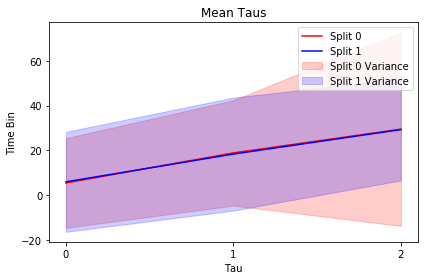

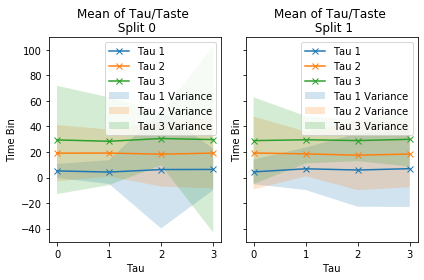

In [19]:
#Plot basic stats

#Plot average tau + variance
avg_plus_var_0 = [avg_0[i]+var_0[i] for i in range(tau_changepoints)]
avg_minus_var_0 = [avg_0[i]-var_0[i] for i in range(tau_changepoints)]
avg_plus_var_1 = [avg_1[i]+var_1[i] for i in range(tau_changepoints)]
avg_minus_var_1 = [avg_1[i]-var_1[i] for i in range(tau_changepoints)]
fig = plt.figure()
plt.plot(range(tau_changepoints),avg_0, label='Split 0', color='red')
plt.fill_between(range(tau_changepoints),avg_minus_var_0,avg_plus_var_0, alpha=0.2, color='red', label='Split 0 Variance')
plt.plot(range(tau_changepoints),avg_1, label='Split 1', color='blue')
plt.fill_between(range(tau_changepoints),avg_minus_var_1,avg_plus_var_1, alpha=0.2, color='blue', label='Split 1 Variance')
plt.title('Mean Taus')
plt.xlabel('Tau')
plt.xticks([0,1,2])
plt.ylabel('Time Bin')
plt.legend()
fig.tight_layout()
plt.savefig(os.path.join(analysis_save_path,'tau_mean'))

#Plot mean of tau across tastes and taus
fig = plt.figure()
all_ax = fig.subplots(1,2,sharey=True)
for i in range(tau_changepoints):
    plt.sca(all_ax[0])
    plt.plot(taste_vals,avg_0_taste[i],'-x', label='Tau '+str(i+1))
    plt.fill_between(taste_vals,np.subtract(avg_0_taste[i],var_0_taste[i]),np.add(avg_0_taste[i],var_0_taste[i]), alpha=0.2, label='Tau '+str(i+1)+' Variance')
    plt.title('Mean of Tau/Taste \n Split 0') 
    plt.xlabel('Tau')
    plt.ylabel('Time Bin')
    plt.legend()
    plt.sca(all_ax[1])
    plt.plot(taste_vals,avg_1_taste[i],'-x', label='Tau '+str(i+1))
    plt.fill_between(taste_vals,np.subtract(avg_1_taste[i],var_1_taste[i]),np.add(avg_1_taste[i],var_1_taste[i]), alpha=0.2, label='Tau '+str(i+1)+' Variance')
    plt.title('Mean of Tau/Taste \n Split 1') 
    plt.xlabel('Tau')
    plt.ylabel('Time Bin')
    plt.legend()
fig.tight_layout()
plt.savefig(os.path.join(analysis_save_path,'tau_mean_per_taste'))

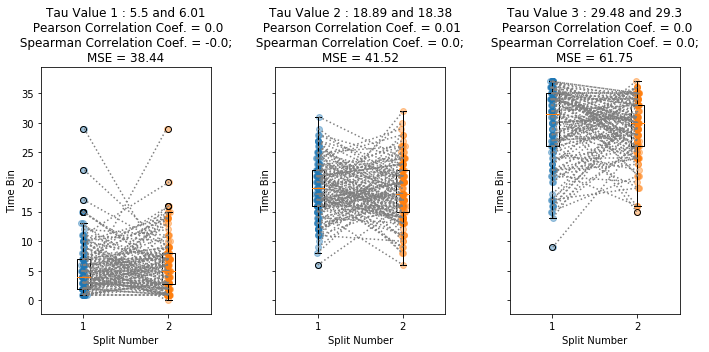

In [20]:
#Plot box+whisker + data points of tau values

fig, all_ax = plt.subplots(1,tau_changepoints,sharey=True, figsize=(10,5))
for i in range(tau_changepoints):
    plt.sca(all_ax[i])
    plt.boxplot([tau_0_modes[:,i],tau_1_modes[:,i]])
    x_1 = 1*np.ones(tau_0_modes[:,i].shape)+np.random.normal(loc=0.0, scale=0.01, size=tau_0_modes[:,i].shape)
    x_2 = 2*np.ones(tau_1_modes[:,i].shape)+np.random.normal(loc=0.0, scale=0.01, size=tau_1_modes[:,i].shape)
    plt.scatter(x_1, tau_0_modes[:,i], alpha=0.4)
    plt.scatter(x_2, tau_1_modes[:,i], alpha=0.4)
    x_combined = np.vstack((x_1.T,x_2.T)).T
    y_combined = np.vstack((tau_0_modes[:,i].T,tau_1_modes[:,i].T)).T
    for j in range(len(y_combined)):
        plt.plot(x_combined[j],y_combined[j],linestyle=':',color='grey')
    plt.title('Tau Value ' + str(i+1) + ' : ' + str(round(avg_0[i],2)) + ' and ' + str(round(avg_1[i],2)) + '\n Pearson Correlation Coef. = '+str(round(p_correlation_coef[i],2)) + '\n Spearman Correlation Coef. = '+str(round(s_correlation_coef[i],2)) +'; \nMSE = '+str(round(mse[i],2))) 
    plt.xlabel('Split Number')
    plt.ylabel('Time Bin')
fig.tight_layout()
plt.savefig(os.path.join(analysis_save_path,'tau_box_whisker'))

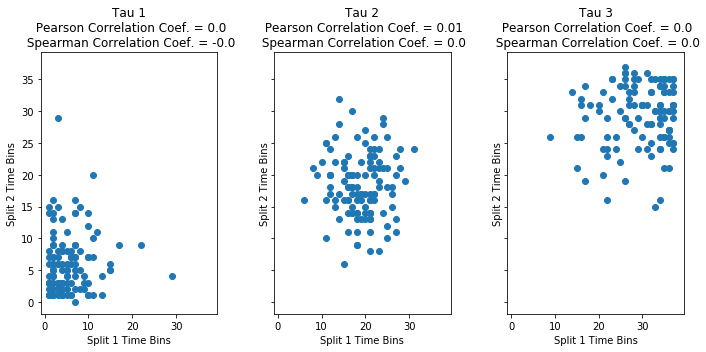

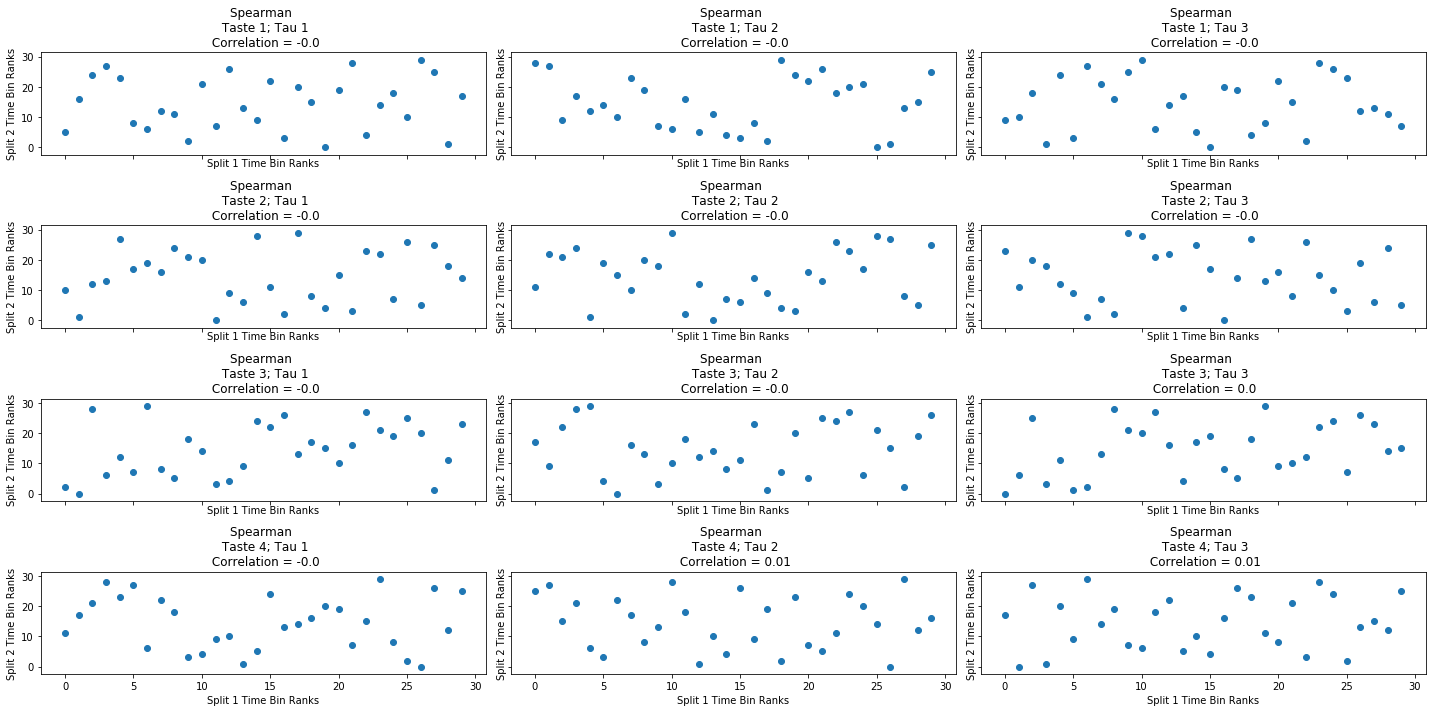

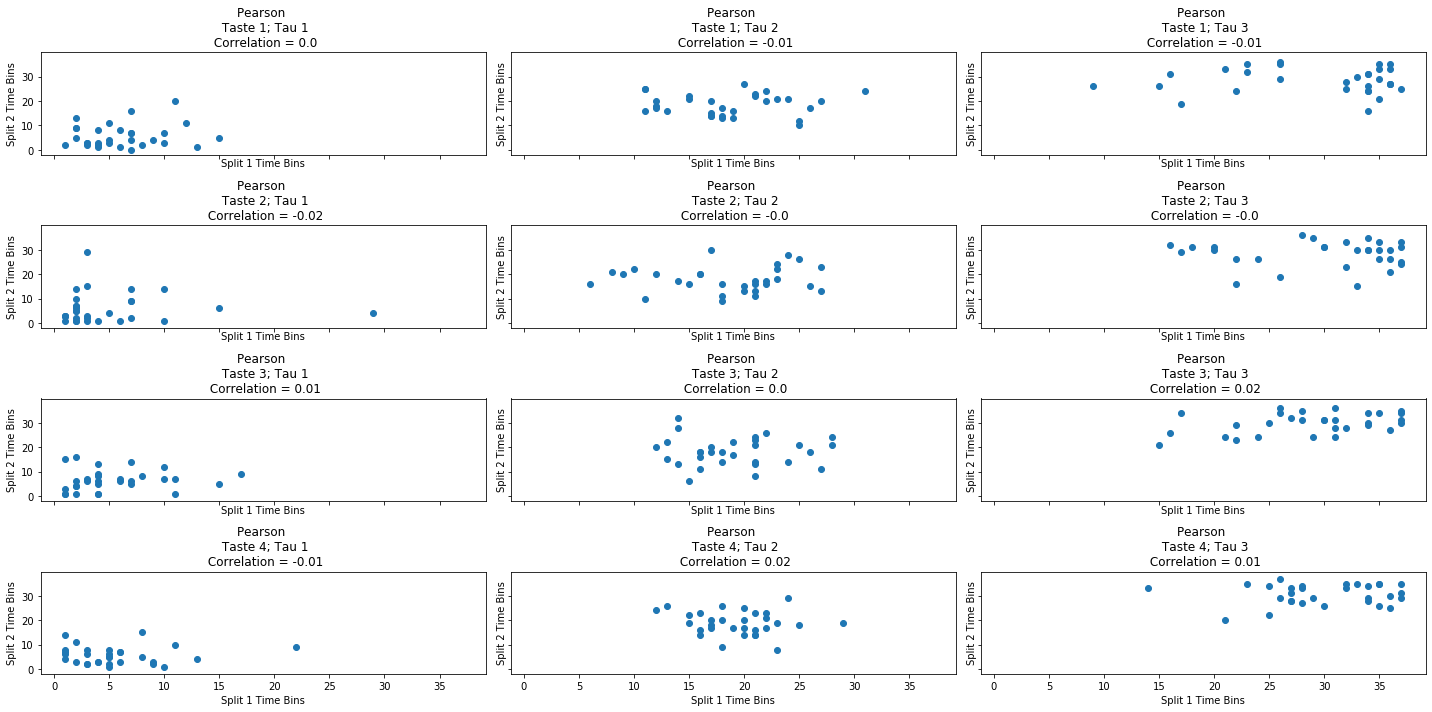

In [21]:
#Tau Correlation Plots

#Overall

#Plot Scatter of Tau Values Against Each Other with Spearman and Pearson Correlations
fig, all_ax = plt.subplots(1,tau_changepoints,sharey=True,sharex=True,figsize=(10,5))
for i in range(tau_changepoints):
    plt.sca(all_ax[i])
    plt.scatter(tau_0_modes[:,i],tau_1_modes[:,i])
    plt.title("Tau " + str(i+1) + '\n Pearson Correlation Coef. = '+str(round(p_correlation_coef[i],2))+ '\n Spearman Correlation Coef. = '+str(round(s_correlation_coef[i],2)))
    plt.xlabel('Split 1 Time Bins')
    plt.ylabel('Split 2 Time Bins')
fig.tight_layout()
#plt.savefig(os.path.join(analysis_save_path,'tau_scatter'))

#By Tastes

#Spearman
fig, all_ax = plt.subplots(len(taste_vals),tau_changepoints,sharey=True,sharex=True,figsize=(20,10))
for i in taste_vals:
    for j in range(tau_changepoints):
        tau_0_shifted = tau_0_modes[taste_label0 == i,j] - np.min(tau_0_modes[taste_label0 == i,j])
        tau_1_shifted = tau_1_modes[taste_label1 == i,j] - np.min(tau_1_modes[taste_label1 == i,j])
        tau_0_argsort = tau_0_shifted.argsort()
        tau_0_sorted = [np.where(tau_0_argsort == i) for i in range(len(tau_0_shifted))] #tau 0 ranks
        tau_1_argsort = tau_1_shifted.argsort()
        tau_1_sorted = [np.where(tau_1_argsort == i) for i in range(len(tau_1_shifted))] #tau 1 ranks
        rho = s_correlation_all_taste[i][j]
        #Plot results
        plt.sca(all_ax[i][j])
        plt.scatter(tau_0_sorted,tau_1_sorted)
        plt.title("Spearman \n Taste " + str(i+1) + "; Tau " + str(j+1) + "\n Correlation = " + str(np.round(rho,2)))
        plt.xlabel('Split 1 Time Bin Ranks')
        plt.ylabel('Split 2 Time Bin Ranks')
plt.tight_layout()


#Pearson
fig, all_ax = plt.subplots(len(taste_vals),tau_changepoints,sharey=True,sharex=True,figsize=(20,10))
for i in taste_vals:
    for j in range(tau_changepoints):
        #first calculate ranks
        tau_0_points = tau_0_modes[taste_label0 == i,j]
        tau_1_points = tau_1_modes[taste_label1 == i,j]
        rho = p_correlation_all_taste[i][j]
        #Plot results
        plt.sca(all_ax[i][j])
        plt.scatter(tau_0_points,tau_1_points)
        plt.title("Pearson \n Taste " + str(i+1) + "; Tau " + str(j+1) + "\n Correlation = " + str(np.round(rho,2)))
        plt.xlabel('Split 1 Time Bins')
        plt.ylabel('Split 2 Time Bins')
plt.tight_layout()

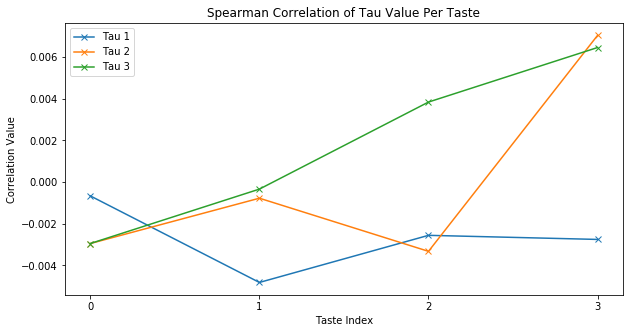

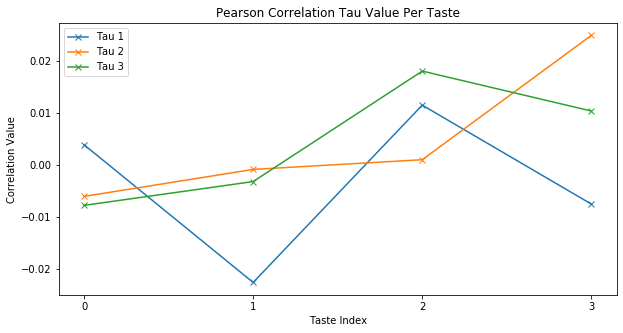

In [22]:
#Plot correlation rho values across tastes and taus (Spearman)

fig = plt.figure(figsize=(10,5))
for i in range(tau_changepoints):
    plt.plot(taste_vals,np.array(s_correlation_all_taste).T[i],'-x',label='Tau '+str(i+1))
plt.title('Spearman Correlation of Tau Value Per Taste') 
plt.ylabel('Correlation Value')
plt.xlabel('Taste Index')
plt.xticks([0,1,2,3])
plt.legend()
plt.savefig(os.path.join(analysis_save_path,'tau_correlation_per_taste'))

#Plot correlation rho values across tastes and taus (Pearson)

fig = plt.figure(figsize=(10,5))
for i in range(tau_changepoints):
    plt.plot(taste_vals,np.array(p_correlation_all_taste).T[i],'-x', label='Tau '+str(i+1))
plt.title('Pearson Correlation Tau Value Per Taste') 
plt.ylabel('Correlation Value')
plt.xlabel('Taste Index')
plt.xticks([0,1,2,3])
plt.legend()
plt.savefig(os.path.join(analysis_save_path,'tau_correlation_p_per_taste'))

## Shuffled Data

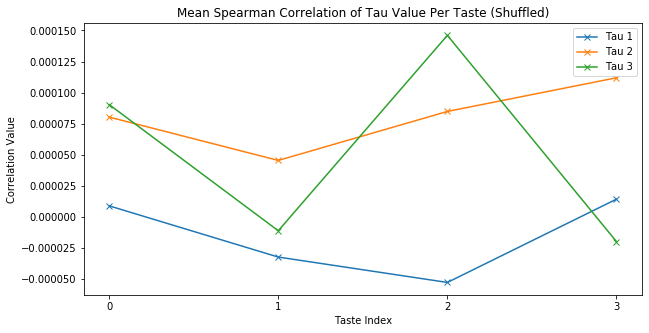

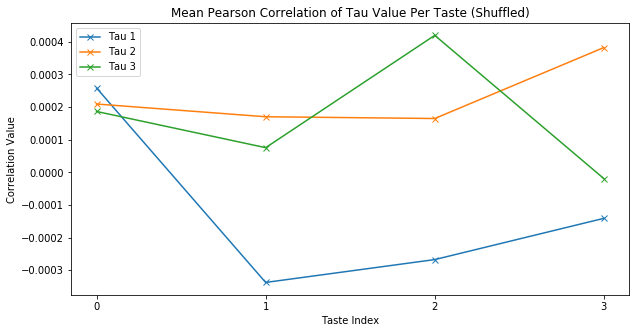

In [23]:
#Plot correlation rho values across tastes and taus

fig = plt.figure(figsize=(10,5))
for i in range(tau_changepoints):
    plt.plot(taste_vals,np.array(s_correlation_coef_taste_shuffled_mean).T[i],'-x',label='Tau '+str(i+1))
plt.title('Mean Spearman Correlation of Tau Value Per Taste (Shuffled)') 
plt.ylabel('Correlation Value')
plt.xlabel('Taste Index')
plt.xticks([0,1,2,3])
plt.legend()
plt.savefig(os.path.join(analysis_save_path,'tau_correlation_per_taste_shuffled'))

#Plot correlation p values across tastes and taus

fig = plt.figure(figsize=(10,5))
for i in range(tau_changepoints):
    plt.plot(taste_vals,np.array(p_correlation_coef_taste_shuffled_mean).T[i],'-x', label='Tau '+str(i+1))
plt.title('Mean Pearson Correlation of Tau Value Per Taste (Shuffled)') 
plt.ylabel('Correlation Value')
plt.xlabel('Taste Index')
plt.xticks([0,1,2,3])
plt.legend()
plt.savefig(os.path.join(analysis_save_path,'tau_correlation_p_per_taste_shuffled'))

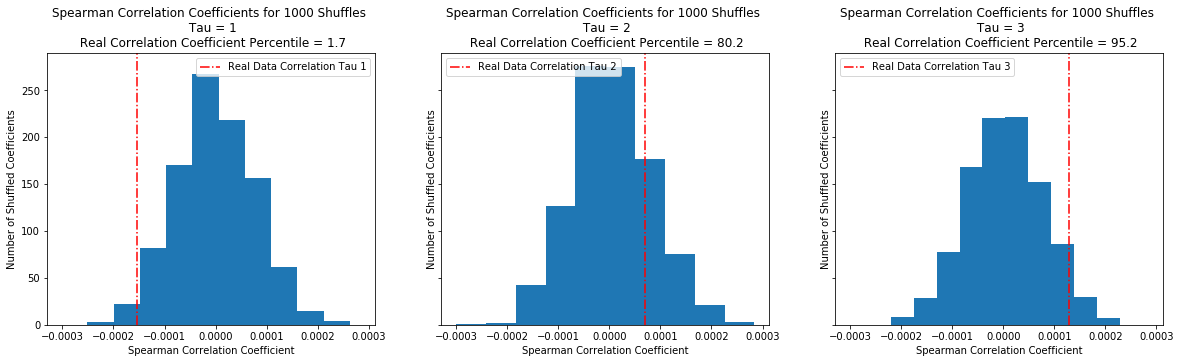

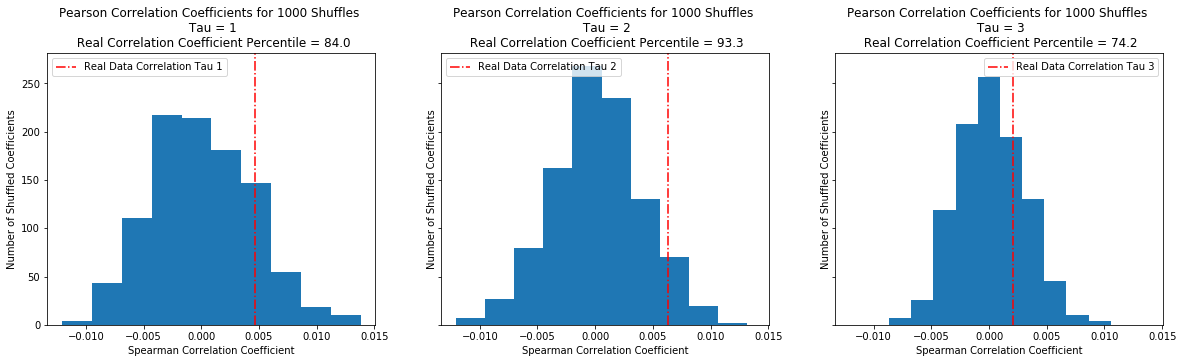

In [24]:
#Histogram of shuffled vs regular correlation coefficients

#Spearman
fig, all_ax = plt.subplots(1,tau_changepoints,sharey=True,sharex=True,figsize=(20,5))
for i in range(tau_changepoints):
    real_percentile = real_s_percentiles[0][i]
    plt.sca(all_ax[i])
    _ = plt.hist(np.array(s_correlation_coef_shuffled).T[i],bins=10)
    plt.axvline(x = s_correlation_coef[i], color = 'r', linestyle = '-.', label = 'Real Data Correlation Tau '+str(i+1))
    plt.title("Spearman Correlation Coefficients for 1000 Shuffles \n Tau = "+str(i+1)+"\n Real Correlation Coefficient Percentile = "+str(round(real_percentile,2)))
    plt.ylabel('Number of Shuffled Coefficients')
    plt.xlabel('Spearman Correlation Coefficient')
    plt.legend()
fig.savefig(os.path.join(analysis_save_path,'spearman_tau_correlation_shuffled_histogram'))
    
    
#Pearson
fig, all_ax = plt.subplots(1,tau_changepoints,sharey=True,sharex=True,figsize=(20,5))
for i in range(tau_changepoints):
    real_percentile = real_p_percentiles[0][i]
    plt.sca(all_ax[i])
    _ = plt.hist(np.array(p_correlation_coef_shuffled).T[i],bins=10)
    plt.axvline(x = p_correlation_coef[i], color = 'r', linestyle = '-.', label = 'Real Data Correlation Tau '+str(i+1))
    plt.title("Pearson Correlation Coefficients for 1000 Shuffles \n Tau = "+str(i+1)+"\n Real Correlation Coefficient Percentile = "+str(round(real_percentile,2)))
    plt.ylabel('Number of Shuffled Coefficients')
    plt.xlabel('Spearman Correlation Coefficient')
    plt.legend()
fig.savefig(os.path.join(analysis_save_path,'pearson_tau_correlation_shuffled_histogram'))

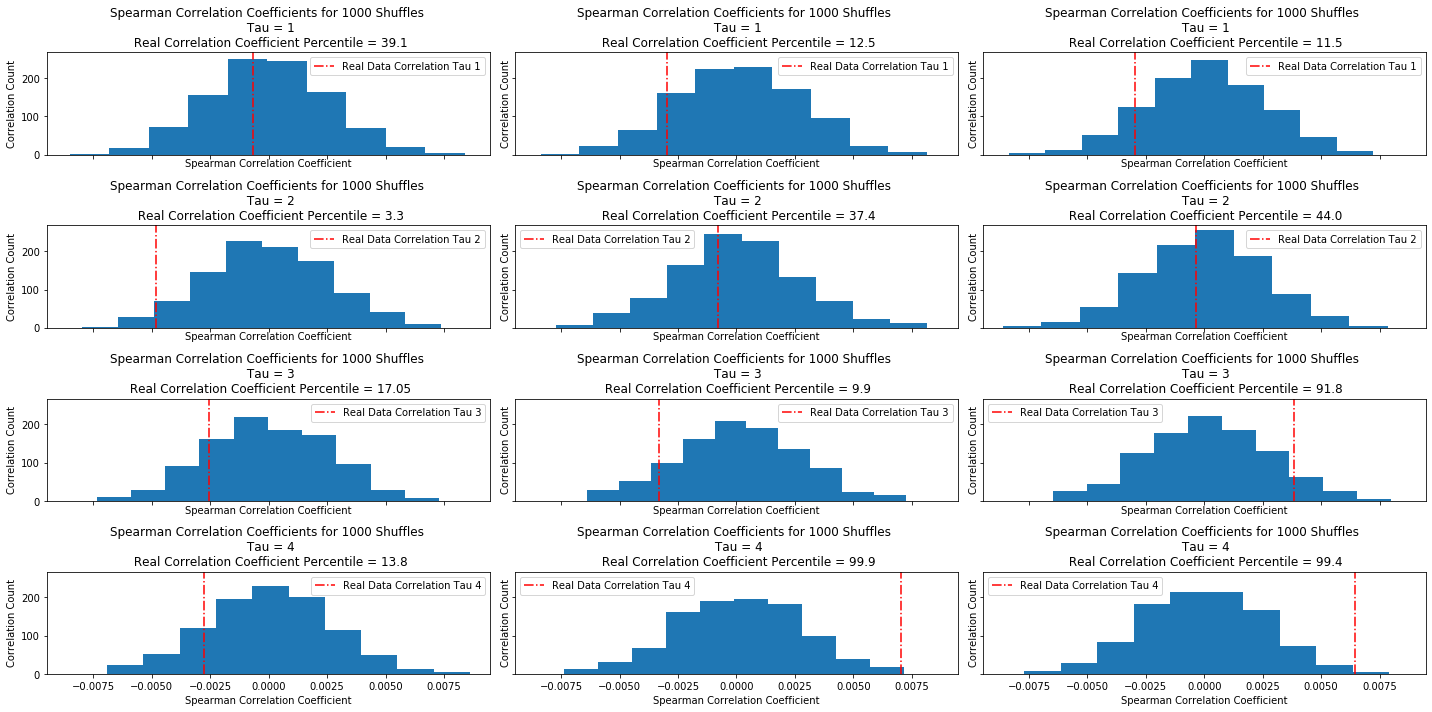

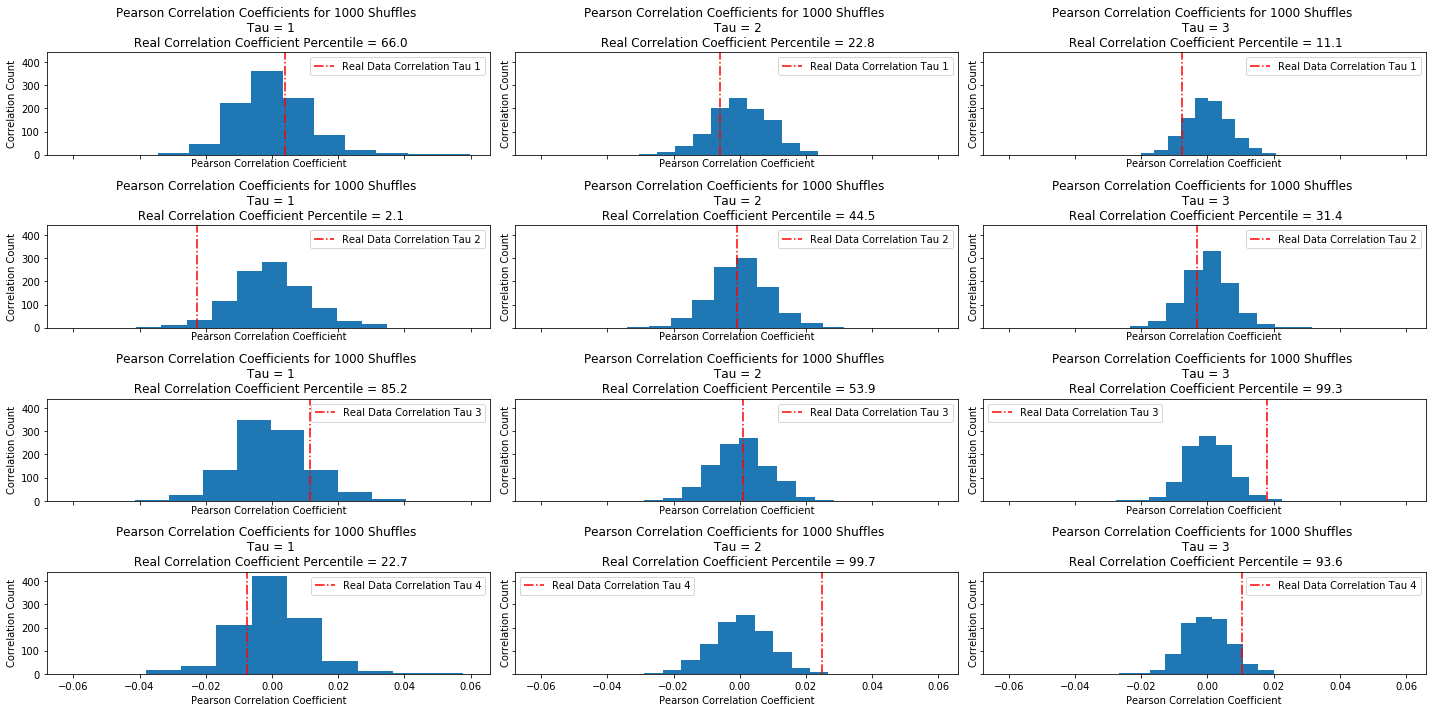

In [25]:
#Histogram of shuffled vs regular correlation coefficients per tastes

#Spearman
fig, all_ax = plt.subplots(len(taste_vals),tau_changepoints,sharey=True,sharex=True,figsize=(20,10))
for i in taste_vals:
    for j in range(tau_changepoints):
        real_percentile = real_s_percentiles_taste[i][j]
        plt.sca(all_ax[i][j])
        _ = plt.hist(np.array(s_correlation_coef_taste_shuffled).T[j][i],bins=10)
        plt.axvline(x = s_correlation_all_taste[i][j], color = 'r', linestyle = '-.', label = 'Real Data Correlation Tau '+str(i+1))
        plt.title("Spearman Correlation Coefficients for 1000 Shuffles \n Tau = "+str(i+1)+"\n Real Correlation Coefficient Percentile = "+str(round(real_percentile,2)))
        plt.ylabel("Correlation Count")
        plt.xlabel('Spearman Correlation Coefficient')
        plt.legend()
fig.tight_layout()
fig.savefig(os.path.join(analysis_save_path,'spearman_tau_correlation_taste_shuffled_histogram'))
    
    
#Pearson
fig, all_ax = plt.subplots(len(taste_vals),tau_changepoints,sharey=True,sharex=True,figsize=(20,10))
for i in taste_vals:
    for j in range(tau_changepoints):
        real_percentile = real_p_percentiles_taste[i][j]
        plt.sca(all_ax[i][j])
        _ = plt.hist(np.array(p_correlation_coef_taste_shuffled).T[j][i],bins=10)
        plt.axvline(x = p_correlation_all_taste[i][j], color = 'r', linestyle = '-.', label = 'Real Data Correlation Tau '+str(i+1))
        plt.title("Pearson Correlation Coefficients for 1000 Shuffles \n Tau = "+str(j+1)+"\n Real Correlation Coefficient Percentile = "+str(round(real_percentile,2)))
        plt.ylabel("Correlation Count")
        plt.xlabel('Pearson Correlation Coefficient')
        plt.legend()
fig.tight_layout()
fig.savefig(os.path.join(analysis_save_path,'pearson_tau_correlation_taste_shuffled_histogram'))

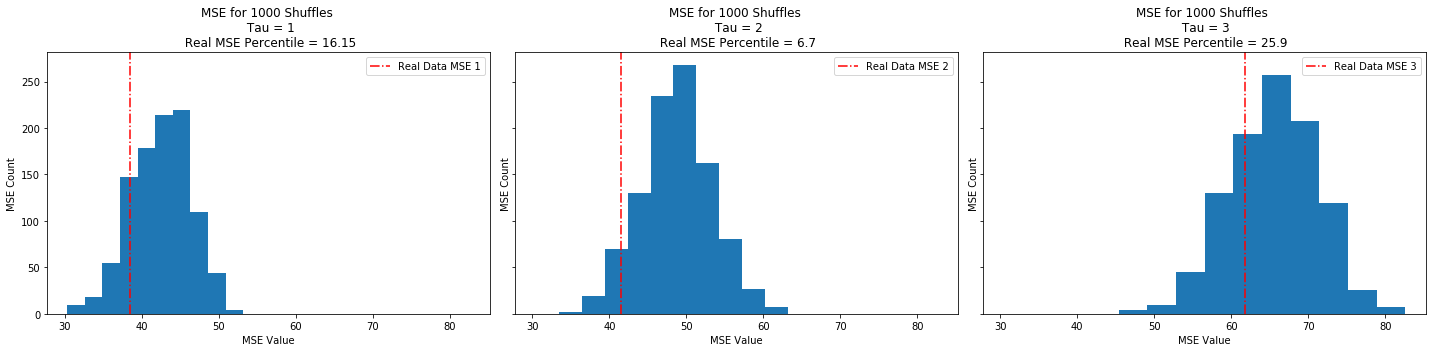

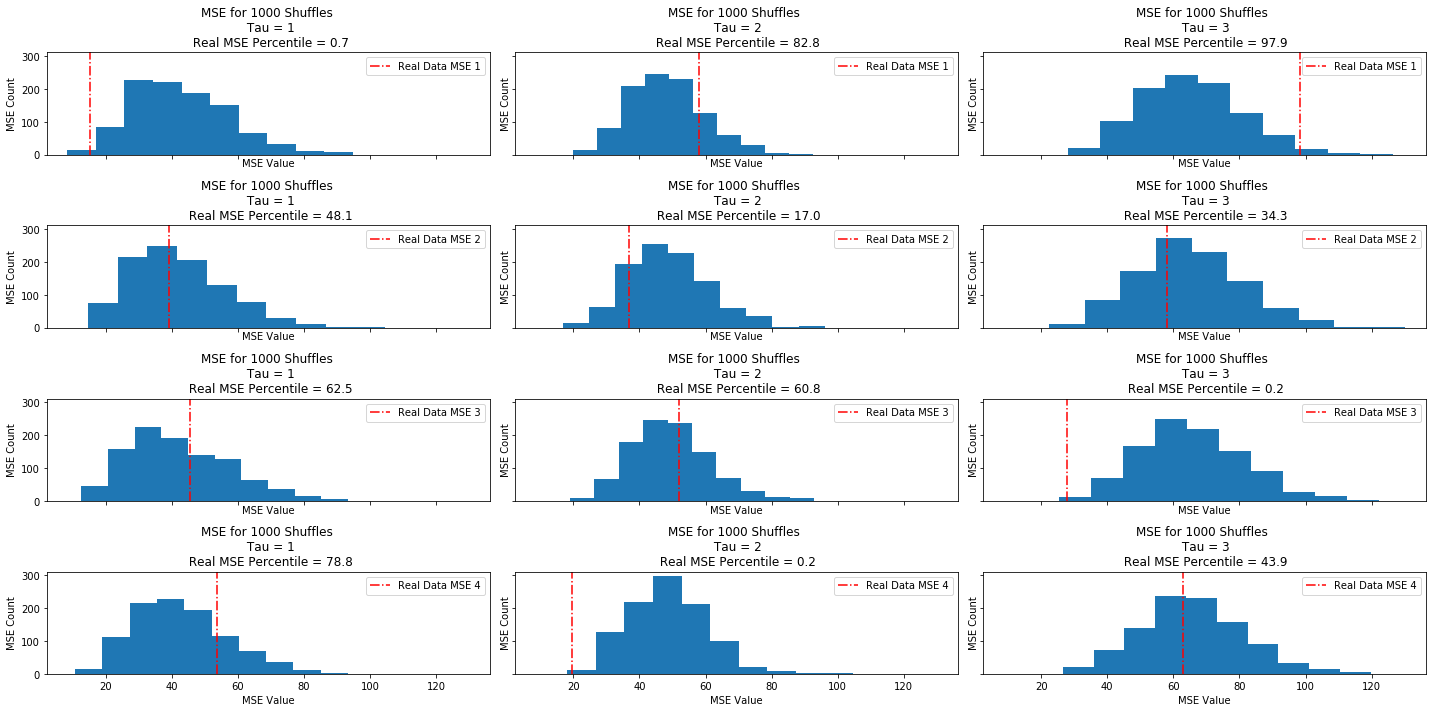

In [26]:
#Histogram of shuffled vs real MSE
fig, all_ax = plt.subplots(1,tau_changepoints,sharey=True,sharex=True,figsize=(20,5))
for i in range(tau_changepoints):
    real_percentile = real_mse_percentiles[0][i]
    plt.sca(all_ax[i])
    _ = plt.hist(np.array(mse_shuffled_all).T[i],bins=10)
    plt.axvline(x = mse[i], color = 'r', linestyle = '-.', label = 'Real Data MSE '+str(i+1))
    plt.title("MSE for 1000 Shuffles \n Tau = "+str(i+1)+"\n Real MSE Percentile = "+str(np.round(real_percentile,2)))
    plt.ylabel("MSE Count")
    plt.xlabel("MSE Value")
    plt.legend()
fig.tight_layout()
fig.savefig(os.path.join(analysis_save_path,'mse_shuffled_histogram'))
    
#Histogram of shuffled vs real MSE by Taste
fig, all_ax = plt.subplots(len(taste_vals),tau_changepoints,sharey=True,sharex=True,figsize=(20,10))
for i in taste_vals:
    for j in range(tau_changepoints):
        real_percentile = real_mse_percentiles_taste[i][j]
        plt.sca(all_ax[i][j])
        _ = plt.hist(np.array(mse_taste_shuffled_all).T[j][i],bins=10)
        plt.axvline(x = mse_taste[j][i], color = 'r', linestyle = '-.', label = 'Real Data MSE '+str(i+1))
        plt.title("MSE for 1000 Shuffles \n Tau = "+str(j+1)+"\n Real MSE Percentile = "+str(np.round(real_percentile,2)))
        plt.ylabel("MSE Count")
        plt.xlabel("MSE Value")
        plt.legend()
fig.tight_layout()
fig.savefig(os.path.join(analysis_save_path,'mse_shuffled_taste_histogram'))
